## 引用套件

In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 10

Using TensorFlow backend.


In [2]:
import keras
keras.__version__

'2.1.2'

## 建立編碼器
- LeakyRelu: 

![alt text][logo]

[logo]: http://p0.ifengimg.com/pmop/2017/0701/C56E5C6FCBB36E70BA5EBC90CBD142BA320B3DF6_size19_w740_h217.jpeg "Logo Title Text 2"

In [3]:
def build_encoder():
    # Encoder
    img = Input(shape=img_shape)
    h = Flatten()(img)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    mu = Dense(latent_dim)(h)
    log_var = Dense(latent_dim)(h)
    latent_repr = merge([mu, log_var],
            mode=lambda p: p[0] + K.random_normal(K.shape(p[0])) * K.exp(p[1] / 2),
            output_shape=lambda p: p[0])

    return Model(img, latent_repr)

## 建立解碼器

In [4]:
def build_decoder():

    model = Sequential()

    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    z = Input(shape=(latent_dim,))
    img = model(z)

    return Model(z, img)

## 建立鑑別模型

In [5]:
def build_discriminator():

    model = Sequential()

    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.summary()

    encoded_repr = Input(shape=(latent_dim, ))
    validity = model(encoded_repr)

    return Model(encoded_repr, validity)

## 訓練過程

In [6]:
def train(epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake  = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        #  Train Discriminator

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        latent_fake = encoder.predict(imgs)
        latent_real = np.random.normal(size=(batch_size, latent_dim))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(latent_real, valid)
        d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #  Train Generator

        # Train the generator
        g_loss = adversarial_autoencoder.train_on_batch(imgs, [imgs, valid])

        # Plot the progress
        print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch)

## 圖片採樣

In [7]:
def sample_images(epoch):
    r, c = 5, 5

    z = np.random.normal(size=(r*c, latent_dim))
    gen_imgs = decoder.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

## 模型存儲

In [8]:
def save_model():

    def save(model, model_name):
        model_path = "saved_model/%s.json" % model_name
        weights_path = "saved_model/%s_weights.hdf5" % model_name
        options = {"file_arch": model_path,
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])

    save(generator, "aae_generator")
    save(discriminator, "aae_discriminator")


## 建立模型流程

In [19]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the encoder / decoder
encoder = build_encoder()
decoder = build_decoder()

img = Input(shape=img_shape)
# The generator takes the image, encodes it and reconstructs it
# from the encoding
encoded_repr = encoder(img)
reconstructed_img = decoder(encoded_repr)

# For the adversarial_autoencoder model we will only train the generator
discriminator.trainable = False

# The discriminator determines validity of the encoding
validity = discriminator(encoded_repr)

# The adversarial_autoencoder model  (stacked generator and discriminator)
adversarial_autoencoder = Model(img, [reconstructed_img, validity])
adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[0.999,0.001],optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               5632      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]
/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


## 開始訓練

In [22]:
train(epochs=2000, batch_size=32, sample_interval=200)

/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.481594, acc: 76.56%] [G loss: 0.066933, mse: 0.065430]
1 [D loss: 0.567188, acc: 73.44%] [G loss: 0.077946, mse: 0.076443]
2 [D loss: 0.497958, acc: 73.44%] [G loss: 0.067028, mse: 0.065652]
3 [D loss: 0.605759, acc: 70.31%] [G loss: 0.086098, mse: 0.084945]
4 [D loss: 0.497271, acc: 78.12%] [G loss: 0.080915, mse: 0.079747]
5 [D loss: 0.569359, acc: 75.00%] [G loss: 0.076652, mse: 0.075257]
6 [D loss: 0.457037, acc: 79.69%] [G loss: 0.081152, mse: 0.079671]
7 [D loss: 0.565794, acc: 71.88%] [G loss: 0.079696, mse: 0.078754]
8 [D loss: 0.502645, acc: 75.00%] [G loss: 0.084255, mse: 0.082866]
9 [D loss: 0.545774, acc: 75.00%] [G loss: 0.076937, mse: 0.075700]
10 [D loss: 0.479671, acc: 79.69%] [G loss: 0.073687, mse: 0.072425]
11 [D loss: 0.550427, acc: 75.00%] [G loss: 0.075667, mse: 0.074392]
12 [D loss: 0.580027, acc: 65.62%] [G loss: 0.081933, mse: 0.080835]
13 [D loss: 0.379523, acc: 85.94%] [G loss: 0.074037, mse: 0.072581]
14 [D loss: 0.424750, acc: 79.69%] [G loss: 

124 [D loss: 0.470458, acc: 84.38%] [G loss: 0.072264, mse: 0.070917]
125 [D loss: 0.580066, acc: 70.31%] [G loss: 0.073628, mse: 0.072304]
126 [D loss: 0.523923, acc: 78.12%] [G loss: 0.071354, mse: 0.070038]
127 [D loss: 0.515629, acc: 73.44%] [G loss: 0.082121, mse: 0.080399]
128 [D loss: 0.421212, acc: 82.81%] [G loss: 0.072135, mse: 0.070731]
129 [D loss: 0.532081, acc: 71.88%] [G loss: 0.077788, mse: 0.076426]
130 [D loss: 0.526952, acc: 73.44%] [G loss: 0.075451, mse: 0.074204]
131 [D loss: 0.483110, acc: 82.81%] [G loss: 0.073347, mse: 0.071834]
132 [D loss: 0.446718, acc: 75.00%] [G loss: 0.075345, mse: 0.074065]
133 [D loss: 0.576379, acc: 64.06%] [G loss: 0.085145, mse: 0.083831]
134 [D loss: 0.513313, acc: 68.75%] [G loss: 0.075578, mse: 0.074180]
135 [D loss: 0.455386, acc: 84.38%] [G loss: 0.070091, mse: 0.068751]
136 [D loss: 0.411968, acc: 85.94%] [G loss: 0.074815, mse: 0.073330]
137 [D loss: 0.441951, acc: 79.69%] [G loss: 0.078264, mse: 0.076725]
138 [D loss: 0.45726

250 [D loss: 0.586988, acc: 65.62%] [G loss: 0.081353, mse: 0.080088]
251 [D loss: 0.483730, acc: 78.12%] [G loss: 0.075408, mse: 0.074248]
252 [D loss: 0.500186, acc: 76.56%] [G loss: 0.075232, mse: 0.073899]
253 [D loss: 0.388824, acc: 85.94%] [G loss: 0.069052, mse: 0.067660]
254 [D loss: 0.521658, acc: 70.31%] [G loss: 0.077270, mse: 0.075816]
255 [D loss: 0.533799, acc: 68.75%] [G loss: 0.075713, mse: 0.074212]
256 [D loss: 0.426769, acc: 78.12%] [G loss: 0.074617, mse: 0.073273]
257 [D loss: 0.364253, acc: 85.94%] [G loss: 0.066866, mse: 0.065315]
258 [D loss: 0.384929, acc: 85.94%] [G loss: 0.073445, mse: 0.071885]
259 [D loss: 0.384345, acc: 81.25%] [G loss: 0.059342, mse: 0.057677]
260 [D loss: 0.439927, acc: 85.94%] [G loss: 0.063529, mse: 0.062101]
261 [D loss: 0.547130, acc: 82.81%] [G loss: 0.074331, mse: 0.073038]
262 [D loss: 0.414582, acc: 85.94%] [G loss: 0.078558, mse: 0.077195]
263 [D loss: 0.544433, acc: 70.31%] [G loss: 0.077490, mse: 0.076092]
264 [D loss: 0.49399

368 [D loss: 0.368380, acc: 89.06%] [G loss: 0.063247, mse: 0.061344]
369 [D loss: 0.412607, acc: 85.94%] [G loss: 0.073099, mse: 0.071587]
370 [D loss: 0.579778, acc: 67.19%] [G loss: 0.075912, mse: 0.074690]
371 [D loss: 0.499473, acc: 73.44%] [G loss: 0.072712, mse: 0.071455]
372 [D loss: 0.577654, acc: 78.12%] [G loss: 0.082383, mse: 0.081247]
373 [D loss: 0.578889, acc: 73.44%] [G loss: 0.090936, mse: 0.089619]
374 [D loss: 0.558673, acc: 70.31%] [G loss: 0.080951, mse: 0.079688]
375 [D loss: 0.592020, acc: 71.88%] [G loss: 0.062201, mse: 0.061013]
376 [D loss: 0.566370, acc: 76.56%] [G loss: 0.074348, mse: 0.073196]
377 [D loss: 0.667436, acc: 64.06%] [G loss: 0.077679, mse: 0.076312]
378 [D loss: 0.417847, acc: 87.50%] [G loss: 0.065434, mse: 0.063798]
379 [D loss: 0.504083, acc: 76.56%] [G loss: 0.078713, mse: 0.077463]
380 [D loss: 0.491283, acc: 79.69%] [G loss: 0.071362, mse: 0.070168]
381 [D loss: 0.494864, acc: 76.56%] [G loss: 0.066499, mse: 0.065251]
382 [D loss: 0.50640

495 [D loss: 0.443577, acc: 82.81%] [G loss: 0.073487, mse: 0.071936]
496 [D loss: 0.441063, acc: 85.94%] [G loss: 0.076478, mse: 0.075096]
497 [D loss: 0.504493, acc: 78.12%] [G loss: 0.073942, mse: 0.072504]
498 [D loss: 0.494945, acc: 79.69%] [G loss: 0.063372, mse: 0.061925]
499 [D loss: 0.406002, acc: 82.81%] [G loss: 0.066525, mse: 0.065119]
500 [D loss: 0.557144, acc: 68.75%] [G loss: 0.088679, mse: 0.087598]
501 [D loss: 0.491150, acc: 76.56%] [G loss: 0.069294, mse: 0.068119]
502 [D loss: 0.405379, acc: 89.06%] [G loss: 0.082873, mse: 0.081319]
503 [D loss: 0.461561, acc: 81.25%] [G loss: 0.069464, mse: 0.067968]
504 [D loss: 0.446993, acc: 84.38%] [G loss: 0.065848, mse: 0.064370]
505 [D loss: 0.396046, acc: 84.38%] [G loss: 0.064513, mse: 0.062938]
506 [D loss: 0.510420, acc: 71.88%] [G loss: 0.080787, mse: 0.079555]
507 [D loss: 0.413674, acc: 87.50%] [G loss: 0.064401, mse: 0.062697]
508 [D loss: 0.502304, acc: 78.12%] [G loss: 0.067753, mse: 0.066379]
509 [D loss: 0.51074

613 [D loss: 0.522900, acc: 73.44%] [G loss: 0.081055, mse: 0.079735]
614 [D loss: 0.398623, acc: 87.50%] [G loss: 0.065826, mse: 0.064311]
615 [D loss: 0.598081, acc: 60.94%] [G loss: 0.087651, mse: 0.086587]
616 [D loss: 0.547876, acc: 73.44%] [G loss: 0.077084, mse: 0.075943]
617 [D loss: 0.429387, acc: 76.56%] [G loss: 0.076191, mse: 0.074694]
618 [D loss: 0.482789, acc: 78.12%] [G loss: 0.078302, mse: 0.076691]
619 [D loss: 0.639137, acc: 71.88%] [G loss: 0.082742, mse: 0.081536]
620 [D loss: 0.381726, acc: 84.38%] [G loss: 0.078721, mse: 0.076928]
621 [D loss: 0.587666, acc: 71.88%] [G loss: 0.087311, mse: 0.086093]
622 [D loss: 0.529045, acc: 75.00%] [G loss: 0.076527, mse: 0.075101]
623 [D loss: 0.589644, acc: 68.75%] [G loss: 0.078184, mse: 0.076881]
624 [D loss: 0.534167, acc: 76.56%] [G loss: 0.069599, mse: 0.068372]
625 [D loss: 0.493485, acc: 79.69%] [G loss: 0.081439, mse: 0.080119]
626 [D loss: 0.426588, acc: 81.25%] [G loss: 0.065492, mse: 0.064118]
627 [D loss: 0.48920

737 [D loss: 0.517186, acc: 79.69%] [G loss: 0.072689, mse: 0.071408]
738 [D loss: 0.458018, acc: 79.69%] [G loss: 0.071993, mse: 0.070704]
739 [D loss: 0.571716, acc: 75.00%] [G loss: 0.073464, mse: 0.072086]
740 [D loss: 0.564146, acc: 71.88%] [G loss: 0.078051, mse: 0.076754]
741 [D loss: 0.483405, acc: 73.44%] [G loss: 0.070001, mse: 0.068749]
742 [D loss: 0.430555, acc: 79.69%] [G loss: 0.067892, mse: 0.066449]
743 [D loss: 0.443899, acc: 82.81%] [G loss: 0.075622, mse: 0.074188]
744 [D loss: 0.405307, acc: 84.38%] [G loss: 0.072213, mse: 0.070674]
745 [D loss: 0.604811, acc: 70.31%] [G loss: 0.071442, mse: 0.070058]
746 [D loss: 0.575745, acc: 70.31%] [G loss: 0.079513, mse: 0.078298]
747 [D loss: 0.384341, acc: 84.38%] [G loss: 0.069977, mse: 0.068356]
748 [D loss: 0.457064, acc: 76.56%] [G loss: 0.076312, mse: 0.074935]
749 [D loss: 0.397145, acc: 82.81%] [G loss: 0.076089, mse: 0.074387]
750 [D loss: 0.369744, acc: 85.94%] [G loss: 0.072304, mse: 0.070758]
751 [D loss: 0.46025

858 [D loss: 0.557180, acc: 75.00%] [G loss: 0.075274, mse: 0.074260]
859 [D loss: 0.433305, acc: 84.38%] [G loss: 0.071854, mse: 0.070366]
860 [D loss: 0.448962, acc: 81.25%] [G loss: 0.076534, mse: 0.075236]
861 [D loss: 0.468049, acc: 78.12%] [G loss: 0.065781, mse: 0.064418]
862 [D loss: 0.413486, acc: 82.81%] [G loss: 0.058403, mse: 0.056851]
863 [D loss: 0.537728, acc: 76.56%] [G loss: 0.060781, mse: 0.059339]
864 [D loss: 0.483023, acc: 75.00%] [G loss: 0.081430, mse: 0.079988]
865 [D loss: 0.579970, acc: 70.31%] [G loss: 0.092776, mse: 0.091542]
866 [D loss: 0.472278, acc: 81.25%] [G loss: 0.060078, mse: 0.058752]
867 [D loss: 0.424561, acc: 82.81%] [G loss: 0.073756, mse: 0.072181]
868 [D loss: 0.409914, acc: 85.94%] [G loss: 0.073768, mse: 0.072454]
869 [D loss: 0.510040, acc: 81.25%] [G loss: 0.078737, mse: 0.077284]
870 [D loss: 0.529795, acc: 73.44%] [G loss: 0.079726, mse: 0.078390]
871 [D loss: 0.548891, acc: 75.00%] [G loss: 0.075936, mse: 0.074780]
872 [D loss: 0.51042

983 [D loss: 0.506829, acc: 78.12%] [G loss: 0.078854, mse: 0.077714]
984 [D loss: 0.377728, acc: 87.50%] [G loss: 0.072391, mse: 0.070866]
985 [D loss: 0.499398, acc: 75.00%] [G loss: 0.077809, mse: 0.076447]
986 [D loss: 0.506695, acc: 71.88%] [G loss: 0.080673, mse: 0.078918]
987 [D loss: 0.419883, acc: 85.94%] [G loss: 0.062419, mse: 0.060885]
988 [D loss: 0.514169, acc: 73.44%] [G loss: 0.064270, mse: 0.063162]
989 [D loss: 0.502765, acc: 76.56%] [G loss: 0.081469, mse: 0.080096]
990 [D loss: 0.497806, acc: 71.88%] [G loss: 0.071265, mse: 0.069981]
991 [D loss: 0.482503, acc: 78.12%] [G loss: 0.076439, mse: 0.075112]
992 [D loss: 0.567189, acc: 79.69%] [G loss: 0.071968, mse: 0.070787]
993 [D loss: 0.395505, acc: 82.81%] [G loss: 0.065473, mse: 0.063861]
994 [D loss: 0.483359, acc: 76.56%] [G loss: 0.075860, mse: 0.074488]
995 [D loss: 0.551317, acc: 75.00%] [G loss: 0.068919, mse: 0.067782]
996 [D loss: 0.511771, acc: 75.00%] [G loss: 0.085175, mse: 0.084061]
997 [D loss: 0.49221

1103 [D loss: 0.497487, acc: 73.44%] [G loss: 0.080499, mse: 0.079034]
1104 [D loss: 0.504523, acc: 73.44%] [G loss: 0.059428, mse: 0.057882]
1105 [D loss: 0.391107, acc: 82.81%] [G loss: 0.064884, mse: 0.063188]
1106 [D loss: 0.420788, acc: 84.38%] [G loss: 0.071025, mse: 0.069587]
1107 [D loss: 0.527404, acc: 76.56%] [G loss: 0.075954, mse: 0.074491]
1108 [D loss: 0.607231, acc: 78.12%] [G loss: 0.078418, mse: 0.077267]
1109 [D loss: 0.459655, acc: 82.81%] [G loss: 0.082588, mse: 0.081048]
1110 [D loss: 0.437238, acc: 81.25%] [G loss: 0.075478, mse: 0.074094]
1111 [D loss: 0.426569, acc: 84.38%] [G loss: 0.061363, mse: 0.059813]
1112 [D loss: 0.420940, acc: 85.94%] [G loss: 0.075764, mse: 0.074197]
1113 [D loss: 0.377083, acc: 87.50%] [G loss: 0.077666, mse: 0.076217]
1114 [D loss: 0.425136, acc: 78.12%] [G loss: 0.055311, mse: 0.053750]
1115 [D loss: 0.524739, acc: 75.00%] [G loss: 0.085126, mse: 0.084014]
1116 [D loss: 0.550495, acc: 78.12%] [G loss: 0.086235, mse: 0.084959]
1117 [

1226 [D loss: 0.518241, acc: 73.44%] [G loss: 0.070828, mse: 0.069448]
1227 [D loss: 0.538893, acc: 73.44%] [G loss: 0.090469, mse: 0.089235]
1228 [D loss: 0.407088, acc: 81.25%] [G loss: 0.067176, mse: 0.065812]
1229 [D loss: 0.460078, acc: 81.25%] [G loss: 0.088079, mse: 0.086835]
1230 [D loss: 0.526662, acc: 73.44%] [G loss: 0.080968, mse: 0.079806]
1231 [D loss: 0.434864, acc: 82.81%] [G loss: 0.072733, mse: 0.071045]
1232 [D loss: 0.401856, acc: 81.25%] [G loss: 0.059869, mse: 0.058208]
1233 [D loss: 0.430402, acc: 85.94%] [G loss: 0.059504, mse: 0.057950]
1234 [D loss: 0.496563, acc: 78.12%] [G loss: 0.061946, mse: 0.060446]
1235 [D loss: 0.584338, acc: 73.44%] [G loss: 0.074984, mse: 0.073799]
1236 [D loss: 0.481410, acc: 71.88%] [G loss: 0.076906, mse: 0.075689]
1237 [D loss: 0.427726, acc: 81.25%] [G loss: 0.072685, mse: 0.071391]
1238 [D loss: 0.471646, acc: 79.69%] [G loss: 0.073452, mse: 0.072158]
1239 [D loss: 0.603478, acc: 68.75%] [G loss: 0.087017, mse: 0.085987]
1240 [

1349 [D loss: 0.560238, acc: 70.31%] [G loss: 0.068412, mse: 0.066990]
1350 [D loss: 0.489589, acc: 73.44%] [G loss: 0.073025, mse: 0.071794]
1351 [D loss: 0.450669, acc: 82.81%] [G loss: 0.077246, mse: 0.075768]
1352 [D loss: 0.413117, acc: 79.69%] [G loss: 0.075231, mse: 0.073715]
1353 [D loss: 0.493946, acc: 76.56%] [G loss: 0.068729, mse: 0.067307]
1354 [D loss: 0.466204, acc: 79.69%] [G loss: 0.068088, mse: 0.066571]
1355 [D loss: 0.513304, acc: 71.88%] [G loss: 0.068095, mse: 0.066747]
1356 [D loss: 0.466095, acc: 76.56%] [G loss: 0.063134, mse: 0.061645]
1357 [D loss: 0.449237, acc: 81.25%] [G loss: 0.069897, mse: 0.068304]
1358 [D loss: 0.394974, acc: 84.38%] [G loss: 0.071919, mse: 0.070426]
1359 [D loss: 0.473472, acc: 79.69%] [G loss: 0.071110, mse: 0.069638]
1360 [D loss: 0.460652, acc: 82.81%] [G loss: 0.061804, mse: 0.060190]
1361 [D loss: 0.518987, acc: 79.69%] [G loss: 0.063992, mse: 0.062467]
1362 [D loss: 0.511143, acc: 76.56%] [G loss: 0.072006, mse: 0.070638]
1363 [

1469 [D loss: 0.462914, acc: 70.31%] [G loss: 0.081493, mse: 0.080142]
1470 [D loss: 0.415197, acc: 81.25%] [G loss: 0.062049, mse: 0.060317]
1471 [D loss: 0.564161, acc: 70.31%] [G loss: 0.066342, mse: 0.064749]
1472 [D loss: 0.431326, acc: 79.69%] [G loss: 0.074211, mse: 0.072748]
1473 [D loss: 0.505094, acc: 78.12%] [G loss: 0.066216, mse: 0.064873]
1474 [D loss: 0.505764, acc: 71.88%] [G loss: 0.079268, mse: 0.077817]
1475 [D loss: 0.468973, acc: 73.44%] [G loss: 0.079200, mse: 0.077575]
1476 [D loss: 0.482630, acc: 71.88%] [G loss: 0.076729, mse: 0.075503]
1477 [D loss: 0.380764, acc: 85.94%] [G loss: 0.066872, mse: 0.065376]
1478 [D loss: 0.670890, acc: 65.62%] [G loss: 0.084099, mse: 0.083032]
1479 [D loss: 0.473504, acc: 81.25%] [G loss: 0.071763, mse: 0.070346]
1480 [D loss: 0.526282, acc: 76.56%] [G loss: 0.072554, mse: 0.071294]
1481 [D loss: 0.394290, acc: 84.38%] [G loss: 0.061586, mse: 0.059683]
1482 [D loss: 0.487511, acc: 76.56%] [G loss: 0.073721, mse: 0.072330]
1483 [

1588 [D loss: 0.593541, acc: 70.31%] [G loss: 0.086744, mse: 0.085549]
1589 [D loss: 0.483813, acc: 79.69%] [G loss: 0.071715, mse: 0.070190]
1590 [D loss: 0.442086, acc: 81.25%] [G loss: 0.074200, mse: 0.072893]
1591 [D loss: 0.364668, acc: 84.38%] [G loss: 0.083135, mse: 0.081667]
1592 [D loss: 0.428038, acc: 81.25%] [G loss: 0.066452, mse: 0.065066]
1593 [D loss: 0.562797, acc: 75.00%] [G loss: 0.073703, mse: 0.072403]
1594 [D loss: 0.435379, acc: 81.25%] [G loss: 0.066404, mse: 0.064971]
1595 [D loss: 0.431415, acc: 84.38%] [G loss: 0.063205, mse: 0.061960]
1596 [D loss: 0.558063, acc: 75.00%] [G loss: 0.087013, mse: 0.085751]
1597 [D loss: 0.408472, acc: 84.38%] [G loss: 0.075261, mse: 0.073727]
1598 [D loss: 0.577689, acc: 75.00%] [G loss: 0.074234, mse: 0.072976]
1599 [D loss: 0.507473, acc: 76.56%] [G loss: 0.068292, mse: 0.066712]
1600 [D loss: 0.493508, acc: 78.12%] [G loss: 0.073390, mse: 0.071943]
1601 [D loss: 0.457774, acc: 78.12%] [G loss: 0.074457, mse: 0.073080]
1602 [

1713 [D loss: 0.466139, acc: 75.00%] [G loss: 0.065791, mse: 0.064284]
1714 [D loss: 0.528430, acc: 68.75%] [G loss: 0.076008, mse: 0.074510]
1715 [D loss: 0.506339, acc: 76.56%] [G loss: 0.079708, mse: 0.078481]
1716 [D loss: 0.509898, acc: 73.44%] [G loss: 0.076105, mse: 0.074674]
1717 [D loss: 0.570262, acc: 76.56%] [G loss: 0.071516, mse: 0.070283]
1718 [D loss: 0.502484, acc: 78.12%] [G loss: 0.073933, mse: 0.072674]
1719 [D loss: 0.479481, acc: 84.38%] [G loss: 0.066548, mse: 0.065095]
1720 [D loss: 0.445813, acc: 82.81%] [G loss: 0.075728, mse: 0.074295]
1721 [D loss: 0.469708, acc: 76.56%] [G loss: 0.070936, mse: 0.069403]
1722 [D loss: 0.456957, acc: 76.56%] [G loss: 0.069532, mse: 0.067985]
1723 [D loss: 0.418808, acc: 79.69%] [G loss: 0.075145, mse: 0.073555]
1724 [D loss: 0.422494, acc: 84.38%] [G loss: 0.060644, mse: 0.059092]
1725 [D loss: 0.426813, acc: 84.38%] [G loss: 0.073118, mse: 0.071535]
1726 [D loss: 0.457976, acc: 84.38%] [G loss: 0.070882, mse: 0.069511]
1727 [

1834 [D loss: 0.503737, acc: 73.44%] [G loss: 0.072215, mse: 0.070759]
1835 [D loss: 0.476655, acc: 76.56%] [G loss: 0.078030, mse: 0.076609]
1836 [D loss: 0.340793, acc: 85.94%] [G loss: 0.063343, mse: 0.061616]
1837 [D loss: 0.530268, acc: 76.56%] [G loss: 0.060611, mse: 0.059208]
1838 [D loss: 0.388149, acc: 89.06%] [G loss: 0.076633, mse: 0.075139]
1839 [D loss: 0.394162, acc: 82.81%] [G loss: 0.053842, mse: 0.052064]
1840 [D loss: 0.449302, acc: 75.00%] [G loss: 0.072703, mse: 0.071291]
1841 [D loss: 0.413984, acc: 87.50%] [G loss: 0.063654, mse: 0.062180]
1842 [D loss: 0.421800, acc: 78.12%] [G loss: 0.063353, mse: 0.061753]
1843 [D loss: 0.460033, acc: 75.00%] [G loss: 0.070075, mse: 0.068547]
1844 [D loss: 0.496558, acc: 79.69%] [G loss: 0.069571, mse: 0.068253]
1845 [D loss: 0.424459, acc: 85.94%] [G loss: 0.076508, mse: 0.074918]
1846 [D loss: 0.445591, acc: 81.25%] [G loss: 0.062589, mse: 0.060992]
1847 [D loss: 0.463530, acc: 84.38%] [G loss: 0.076739, mse: 0.075558]
1848 [

1951 [D loss: 0.486423, acc: 79.69%] [G loss: 0.066457, mse: 0.065098]
1952 [D loss: 0.465402, acc: 79.69%] [G loss: 0.055251, mse: 0.053620]
1953 [D loss: 0.521063, acc: 78.12%] [G loss: 0.066460, mse: 0.064744]
1954 [D loss: 0.541448, acc: 75.00%] [G loss: 0.071643, mse: 0.069928]
1955 [D loss: 0.484558, acc: 82.81%] [G loss: 0.070992, mse: 0.069708]
1956 [D loss: 0.468402, acc: 82.81%] [G loss: 0.062938, mse: 0.061332]
1957 [D loss: 0.419612, acc: 85.94%] [G loss: 0.068164, mse: 0.066754]
1958 [D loss: 0.445371, acc: 82.81%] [G loss: 0.072540, mse: 0.071019]
1959 [D loss: 0.419468, acc: 82.81%] [G loss: 0.065054, mse: 0.063320]
1960 [D loss: 0.451051, acc: 82.81%] [G loss: 0.074791, mse: 0.073245]
1961 [D loss: 0.468784, acc: 85.94%] [G loss: 0.068531, mse: 0.067270]
1962 [D loss: 0.414094, acc: 81.25%] [G loss: 0.072580, mse: 0.070893]
1963 [D loss: 0.472044, acc: 82.81%] [G loss: 0.078289, mse: 0.077068]
1964 [D loss: 0.388793, acc: 84.38%] [G loss: 0.064952, mse: 0.063442]
1965 [

## 產生生成圖

In [23]:
import os
os.listdir('images')

['mnist_2800.png',
 'mnist_3600.png',
 'mnist_800.png',
 'mnist_1200.png',
 'mnist_1000.png',
 'mnist_3400.png',
 'mnist_3000.png',
 'horse2zebra',
 'mnist_1400.png',
 'mnist_1600.png',
 'mnist_0.png',
 'mnist_3200.png',
 'mnist_1800.png',
 'mnist_200.png',
 'mnist_3800.png',
 'mnist_600.png',
 'mnist_400.png',
 'mnist_2400.png',
 'mnist_2600.png',
 'mnist_2200.png',
 'mnist_2000.png']

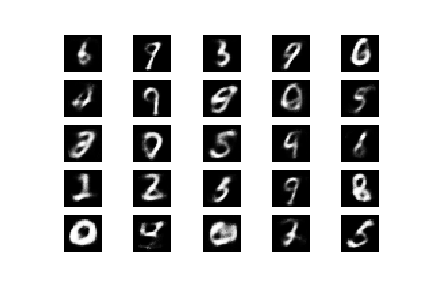

In [24]:
from PIL import Image
Image.open('images/mnist_0.png')